# 前言：

本次利用Tensorflow-Keras实现YOLO-V3模型，目的是自己动手实现YOLO-V3的重要结构，这样才能更为深入了解模型以及提升编程能力；略去了不太重要的结构，如tiny版本就没有继续实现。

重点研究了模型结构，以及细节性但较为重要的非最大值抑制、loss函数、如何生成true label等；

另外做了些测试：图像目标检测、视频实时目标检测测试。

<img src="readme_pic/YOLO_V3_Structure.png" style="width:1000px;height:100;">

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
import keras
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers  import Flatten, Concatenate
from tensorflow.keras import Model, Input
from tensorflow.keras.losses import binary_crossentropy

import numpy as np
import pandas as pd

import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import os
from time import time

Using TensorFlow backend.


In [2]:
def preprocesing_image(file_path):
    '''
    处理流程：读取 --> resize至模型的输入尺寸 --> 归一化为[0,1]--> 升维,增加batch维度
    
    Returns: 
    --------
    img_resized_array: shape(1,416,416,3)
    '''
    
    
    img = Image.open(file_path)
    img_resized = img.resize((416,416))
    img_resized_array = np.asarray(img_resized)
    img_resized_array = img_resized_array / 255.
    img_resized_array = np.expand_dims(img_resized_array, 0)
    
    return img_resized_array

In [3]:
def load_anchors(file_path):
    '''
    加载anchors文件
    
    Returns：
    -------
    anchors: shape(9,2)
    '''
    with open(file_path) as f:
        anchors = f.readline()
    anchors = np.array([int(item.strip()) for item in anchors.split(',')]).reshape([-1,2])
    
    return anchors

In [4]:
def load_class_name(file_path):
    '''
    加载类别文件
    
    Returns：
    -------
    class_name: 类型为list
    '''
    with open(file_path) as f:
        class_name = f.readlines()
    class_name = [item.strip() for item in class_name]
    
    return class_name

In [5]:
def sigmoid(x):
    y = 1 / (1+np.exp(-x))
    return y

In [6]:
def iou(box1, box2):
    
    '''
    box1、box2: xmin,ymin,xmax,ymax
    
    Returns
    -------
    iou_score: float,shape(0)

    '''
    
    intersect_x_min = np.max([box1[0], box2[0]])
    intersect_y_min = np.max([box1[1], box2[1]])
    intersect_x_max = np.min([box1[2], box2[2]])
    intersect_y_max = np.min([box1[3], box2[3]])
    
    intersect_area = (intersect_x_max - intersect_x_min) * (intersect_y_max - intersect_y_min)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou_score = intersect_area / (box1_area + box2_area - intersect_area)
    
    return iou_score

In [7]:
def iou_batch_array(box1, box2):
    
    '''
    Parameters
    ----------
    box: shape(batch,n,n,3,4)
    
    
    Returns
    --------
    iou_score: shape(batch,n,n,3)
    '''
    intersect_x_min = K.maximum(box1[..., 0], box2[..., 0])
    intersect_y_min = K.maximum(box1[..., 1], box2[..., 1])
    intersect_x_max = K.minimum(box1[..., 2], box2[..., 2])
    intersect_y_max = K.minimum(box1[..., 3], box2[..., 3])
    
    
    intersect_area = (intersect_x_max - intersect_x_min) * (intersect_y_max - intersect_y_min)
    
    box1_area = (box1[..., 2] - box1[..., 0]) * (box1[..., 3] - box1[..., 1])
    box2_area = (box2[..., 2] - box2[..., 0]) * (box2[..., 3] - box2[..., 1])
    
    iou_score = intersect_area / (box1_area + box2_area - intersect_area)
    
    
    
    return iou_score

In [8]:
def non_max_suspension(scores, boxes, iou_threshold, max_box):
    '''
    Parameters
    ----------
    scores: 某一个class类别下，shape(n,1)
    boxes: 某一个class类别下，shape(n,4)
    iou_threshold: iou阈值，剔除高于阈值的box
    max_box: TODO, 该class类别下，保留最多几个。
    
    Returns
    -------
    box_collect: 某个类别下，做非最大值抑制后，保留下来的box，[(xmin,ymin,xmax,ymax,score),...]
    
    '''
    
    # 用于收集确认的box
    box_collect = []
    box_score_array = np.concatenate([boxes, scores.reshape((-1,1))], axis=-1)
    
    
    if len(scores) == 1:
        box_collect.append(box_score_array[0])
        return box_collect
    
    else:
        FLAG = 1
        while FLAG:
            # 拿分数排名第一的box和其余box计算iou
            box_score_array = box_score_array[np.argsort(-box_score_array[:,-1])]
            to_drop_row = [0] # 用于收集要删除的box
            for i in range(1, box_score_array.shape[0]):
                iou_score = iou(box_score_array[0], box_score_array[i])
                if iou_score >= iou_threshold:
                    to_drop_row.append(i)

            box_collect.append(box_score_array[0])
            box_score_array  = np.delete(box_score_array, obj=to_drop_row, axis=0)

            if len(box_score_array)>=2:
                FLAG = 1
            elif len(box_score_array)==1:
                box_collect.append(box_score_array[0])
                FLAG = 0
            else:
                FLAG = 0
            
    return box_collect

In [9]:
def make_grids(grid_num_of_layer=[13,26,52]):
    '''
    为3个输出y分别生成gridmap，帮助处理转换box的x，y
    
    Returns
    -------
    result: [shape(13,13,3,2), shape(26,26,3,2), shape(52,52,3,2)]
    '''
    
    result = []
    for num in grid_num_of_layer:
        grid = np.zeros((num, num, 3,2))
        
        for x in range(num):
            for y in range(num):
                grid[x,y,:,:] = [y, x]
        result.append(grid)   
        
    return result

<img src="readme_pic/xywh_transform.png" style="width:400px;height:200;">
<caption><center> 预测结果转换 </center></caption>

In [10]:
def output_score_and_xywh(yolo_output, anchors, grids, input_shape):
    '''
    Parameters
    ----------
    input_shape: int,如416, 默认模型输入x\y维度相同
    yolo_output: [shape(batch,13,13,255), shape(batch,26,26,255), shape(batch,52,52,255)]
                 255: 3*(5+80)
                      5: x_t, y_t, wlogit, h_t, confidence， 需要做转换
                      80: 80个类别对应的概率，需要做转换
    anchors: shape(9,2)
    grids : [shape(batch,13,13,3,2), shape(batch,26,26,3,2), shape(batch,52,52,3,2)]
    
    Returns
    -------
    box_xymin_xymax: shape(batch, 10647, 4)，每个格子（包含三个layer13、26、52）的左上角、右下角坐标; 大小为[0,1]
    box_score:       shape(batch, 10647, 1)，每个格子（包含三个layer13、26、52）的有object的概率
    '''
    
    num_layers = len(anchors) // 3

    box_xy_ = []
    box_wh_ = []
    box_score_ = []
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]]

    num_batch = yolo_outputs[0].shape[0]

    for l in range(num_layers):

        grid_shape = 13 * (2**l)
        output = yolo_outputs[l].reshape([num_batch, grid_shape, grid_shape, 3, 85])

        box_xy_t = output[..., 0:2]
        box_wh_t = output[..., 2:4]
        box_confidence_t = output[..., 4:5]
        box_class_prob_t = output[..., 5:]

        anchor_tensor = anchors[anchor_mask[l]]
        grid = grids[l]

        # 模型输出结果yolo-outputs的转换(见上图)
        box_xy = (sigmoid(box_xy_t) + grid) / grid_shape
        box_wh = np.exp(box_wh_t) * anchor_tensor / input_shape
        box_confidence = sigmoid(box_confidence_t)
        box_class_prob = sigmoid(box_class_prob_t)



        box_xy = box_xy.reshape((num_batch, -1, 2))
        box_wh = box_wh.reshape((num_batch, -1, 2))
        box_score = box_confidence * box_class_prob
        box_score = box_score.reshape((num_batch, -1, 80))

        box_xy_.append(box_xy)
        box_wh_.append(box_wh)
        box_score_.append(box_score)

    box_xy = np.concatenate(box_xy_, axis=1)
    box_wh = np.concatenate(box_wh_, axis=1)

    box_xymin_xymax = np.concatenate([box_xy - box_wh / 2, box_xy + box_wh / 2], axis=-1)
    box_score = np.concatenate(box_score_, axis=1)
    
    return box_xymin_xymax, box_score

In [11]:
def make_y_true(true_boxes, num_classes, anchors, input_shape):
    
    '''
    true_boxes = pd.read_table('test_image/dog.txt',header=None, sep=' ').values
    #xywh为相对值形式(即如：bx=200/416)：class_id,bx,by,bw,bh  此为labelimage生成的yolo格式。
    #如：3, 0.1, 0.2, 0.14, 0.24
    
    input_shape = 416
    
    num_classes = 80
    
    anchors = shape(9,2)，原始的像素数值 load_anchors('model_data/yolo_anchors.txt')
              形式：shape=(9,2) [w,h]
    
    Returns
    -------
    y_true: shape(1,  13*13*225 + 26*26*225 + 52*52*225)
                                 
                                     原 y_true_1/y_true_2/y_true_3 
                                     格式为 xywhpc
                                     xywh为相对值
                                     p = 1
                                     c = [0,0,...,0,1,0,...,0]
    '''


    #创建全0的y_true
    y_true = [np.zeros(shape=(i,i,3,5+num_classes)) for i in [13,26,52]]
    anchor_index = [[6,7,8], [3,4,5], [0,1,2]]
    anchors = anchors / input_shape # 转换为比例形式,大小范围为[0，1]
    box_anchor_indexs = []
    
    for box in true_boxes:
        iou_score_list = []
        class_index = int(box[0]) # 该box下的类别编号
        box_for_iou = np.concatenate([-box[3:] / 2, box[3:] / 2]) # 用于计算该box和9个anchors的iou，选择最大的那个anchor

        for anchor in anchors:
            anchor = np.concatenate([-anchor / 2, anchor / 2])
            iou_score_list.append(iou(box_for_iou, anchor))
        iou_max_index = np.argmax(iou_score_list) #选择最大的那个anchor索引
        # 假如iou_max_index = 5
        
        for i, item in enumerate(anchor_index): 
            if iou_max_index in item:
                # 那么 5 in [3,4,5]，可以确定是26这层，下面确定是layer26的哪个anchor
                # 此时i = 1
                
                anch = item.index(iou_max_index) 
                 # 2 = [3,4,5].index(5)
                
                # 于是，对于某个box,确定了它和9个anchor中的哪个iou最大，然后给y_true赋值即可，根据true_box生成y_true
                
                x_grid = int(box[1] * 13*(i+1)) 
                y_grid = int(box[2] * 13*(i+1))

                #确定y_true
                y_true[i][x_grid, y_grid, anch, :4] = box[1:]
                y_true[i][x_grid, y_grid, anch, 4:5] = 1
                y_true[i][x_grid, y_grid, anch, 5+class_index] = 1

                break

    # 此处将y1 y2 y3 flat后再concatenate为一个输出，和model的output对应
    y_true_1 = y_true[0].reshape(1,-1)
    y_true_2 = y_true[1].reshape(1,-1)
    y_true_3 = y_true[2].reshape(1,-1)
    y_true = np.concatenate([y_true_1,y_true_2,y_true_3], axis=-1)
        
    
    return y_true


In [12]:
def draw_box(img, box_xymin_xymax, box_score):
    
    num_batch = box_xymin_xymax.shape[0]
    for b in range(num_batch):

        class_box_score_dict = {}

        for i, c in enumerate(class_names):

            c_index_list = list(np.argwhere(box_score[b][:, i]>0.6).reshape(-1))

            if len(c_index_list) == 0:
                continue


            boxs = box_xymin_xymax[b][c_index_list]
            scores = box_score[b][c_index_list, i]

            class_box_score_dict.update({c: non_max_suspension(scores, boxs, iou_threshold=0.5, max_box=10)})
            
            
        w, h = img.shape[:2]
        img = img * 225
        img = img.astype('uint8')
        for key in class_box_score_dict.keys():

            for item in class_box_score_dict[key]:

                xmin,ymin,xmax,ymax = item[:4]
                prob = str(round(item[4], 4))
                draw_xmin, draw_xmax = np.array([xmin, xmax]) * h
                draw_ymin, draw_ymax = np.array([ymin, ymax]) * w
#                 draw.rectangle([draw_xmin, draw_ymin, draw_xmax,draw_ymax], width=2, outline=(250))

#                 draw.rectangle([draw_xmin, draw_ymin-20, draw_xmin+ 12*len(key), draw_ymin], fill=250,width=2, outline=(250))
#                 draw.text((draw_xmin, draw_ymin-20), key, font=fnt, fill=(255,255,255))
               
                
                cv.rectangle(img, (int(draw_xmin), int(draw_ymin)),(int(draw_xmax),int(draw_ymax)),(255,255,0),2)
#                 cv.rectangle(img, (int(draw_xmin), int(draw_ymin-20)), (int(draw_xmin+ 12*len(key)+90), int(draw_ymin)), (255,255,0),2)

                cv.putText(img, key+'  '+ prob, (int(draw_xmin), int(draw_ymin-10)), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return img
    

In [13]:
def yolo_v3_loss(y_true, y_pred, grids=None, input_shape=416, anchors=None, ignore_threshold=0.4):
    '''
    y_true: [(batch, 13, 13, 3, 85),(batch, 26, 26, 3, 85),(batch, 52, 52, 3, 85)]
    y_pred: [(batch, 13, 13, 3, 85),(batch, 26, 26, 3, 85),(batch, 52, 52, 3, 85)]
    grid  : [(13, 13, 3, 2),(26, 26, 3, 2),(52, 52, 3, 2)] # 针对, y
    input_shape = 416 #默认输入图像转换为长宽相同
    anchors: (9,2)
    '''
    
    y_pred_1 = y_pred[:, :13*13*255]
    y_pred_2 = y_pred[:, 13*13*255: 26*26*255 +13*13*255]
    y_pred_3 = y_pred[:, 26*26*255 +13*13*255: ]
    
    y_pred = [tf.reshape(y_pred_1, (-1, 13,13,3,85)),
             tf.reshape(y_pred_2, (-1, 26,26,3,85)),
             tf.reshape(y_pred_3, (-1, 52,52,3,85))]
    y_pred = [tf.cast(item, dtype=tf.dtypes.float64) for item in y_pred]

    
    
    y_true_1 = y_true[:, :13*13*255]
    y_true_2 = y_true[:, 13*13*255: 26*26*255 +13*13*255]
    y_true_3 = y_true[:, 26*26*255 +13*13*255: ]
    
    y_true = [tf.reshape(y_true_1, (-1, 13,13,3,85)),
              tf.reshape(y_true_2, (-1, 26,26,3,85)),
              tf.reshape(y_true_3, (-1, 52,52,3,85))]
    y_true = [tf.cast(item, dtype=tf.dtypes.float64) for item in y_true]

    
    
    num_layers = 3
    
#     错误 num_batch = tf.cast(y_true[0].shape[0], dtype=tf.dtypes.float64)
    num_batch = tf.cast(tf.shape(y_true[0])[0], dtype=tf.dtypes.float64)
    
    
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]]
    loss = 0
    for l in range(num_layers):
        grid_shape = 13 * 2**l
        
        object_mask = y_true[l][..., 4:5]
        true_xy_ingrid = y_true[l][..., :2] * grid_shape - grids[l]
        true_wh_ingrid = tf.log(y_true[l][..., 2:4] * input_shape / anchors[anchor_mask[l]])
        true_class_ingrid = y_true[l][..., 5:]
        box_loss_scale = 2 - y_true[l][..., 2:3] * y_true[l][..., 3:4]
        
        
        true_box_wh = y_true[l][..., 2:4] / 2.
        true_xywh = tf.concat([-true_box_wh, true_box_wh], axis=-1)
        anchor_box = anchors[anchor_mask[l]] / input_shape / 2.
        
        anchor_xywh = tf.concat([-anchor_box, anchor_box], axis=-1)
        
          
#         错误：anchor_xywh = tf.zeros(shape=true_xywh.shape, dtype=tf.dtypes.float64) + anchor_xywh
        anchor_xywh = tf.zeros(shape=tf.shape(true_xywh), dtype=tf.dtypes.float64) + anchor_xywh
        anchor_xywh = tf.cast(anchor_xywh, dtype=tf.dtypes.float32)
        true_xywh = tf.cast(true_xywh, dtype=tf.dtypes.float32)
        
        iou_scores = iou_batch_array(anchor_xywh, true_xywh)
        iou_scores = tf.cast(iou_scores, dtype=tf.dtypes.float64)
        
        ignored_mask = iou_scores < ignore_threshold
        ignored_mask = K.expand_dims(ignored_mask,-1)
        ignored_mask = tf.cast(ignored_mask, tf.dtypes.float64)
        
        # 计算xy_loss
#         print(true_xy_ingrid)
#         print(y_pred[l][..., :2])
        bi_CE = binary_crossentropy(true_xy_ingrid, tf.cast(y_pred[l][..., :2], dtype=tf.dtypes.float64), from_logits=True)
        bi_CE = tf.expand_dims(bi_CE, -1)
        xy_loss = object_mask * box_loss_scale * bi_CE
        # 计算wh_loss
        wh_loss = object_mask * box_loss_scale * 0.5* tf.reduce_sum(tf.square(true_xy_ingrid - y_pred[l][..., 2:4]), axis=-1,keepdims=True)
        # 计算confi_loss       
        bi_CE = binary_crossentropy(object_mask, tf.cast(y_pred[l][..., 4:5], dtype=tf.dtypes.float64), from_logits=True)
        bi_CE = tf.expand_dims(bi_CE, -1)
        confi_loss = object_mask * bi_CE + (1 - object_mask) * ignored_mask * bi_CE 
        #(1 - object_mask) * ignored_mask * bi_CE为背景惩罚损失
        
        # 计算class_loss
        bi_CE = binary_crossentropy(true_class_ingrid, tf.cast(y_pred[l][...,5:], dtype=tf.dtypes.float64), from_logits=True)
        bi_CE = tf.expand_dims(bi_CE, -1)
        class_loss = object_mask * bi_CE
        
        
        xy_loss = xy_loss / num_batch
        
        wh_loss = wh_loss / num_batch
        
        confi_loss = confi_loss / num_batch
        class_loss =  class_loss/ num_batch
        
        temp = xy_loss + wh_loss + confi_loss + class_loss
        temp = tf.cast(temp, dtype=tf.dtypes.float32)
        
        loss += tf.reduce_sum(temp)
        
    
    return loss



In [14]:
def CBL_module(x, filters, kernel_size, strides=(1,1), padding='same'):
    '''
    Convnet + Batchnormalization + LeakyRelu
    '''
    x = Conv2D(filters, kernel_size, strides, padding, 
               data_format=None, dilation_rate=(1, 1), 
               activation=None, activity_regularizer=None,
               use_bias=False, bias_initializer='zeros', bias_regularizer=None, 
               kernel_initializer='uniform', kernel_regularizer='l2',  
               kernel_constraint=None, bias_constraint=None)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    return x


def Res_module(x, filters, res_num):
    '''
    ZeroPading + CBL + (CBL+CBL+Add) * num
    '''
    
    x = ZeroPadding2D(padding=((1,0), (1,0)))(x)
    x = CBL_module(x,  filters, kernel_size=(3,3), strides=(2,2), padding='valid')
    
    for i in range(res_num):
        y = CBL_module(x, filters//2, kernel_size=(1,1), strides=(1,1), padding='same')
        z = CBL_module(y, filters, kernel_size=(3,3), strides=(1,1), padding='same')
        x = Add()([z,x])

    return x

In [15]:
def YOLOV3():
    '''
    YOLO V3 主框架
    
    Returns
    -------
    model： 其中model.output 为 shape(batch,  13*13*225 + 26*26*225 + 52*52*225) 即(1, 904995)
    
    '''
    inp = Input(shape=(416,416,3))

    #CBL
    x = CBL_module(inp, filters=32, kernel_size=(3,3), strides=(1,1), padding='same')
    #Res1
    x = Res_module(x, 64, 1)
    #Res2
    x = Res_module(x, 128, 2)
    #Res8
    xx = Res_module(x, 256, 8) # 分支xx
    #Res8
    yy = Res_module(xx, 512, 8) # 分支yy
    #Res4
    z = Res_module(yy, 1024, 4)


    #-----输出y1
    #CBL*5
    z = CBL_module(z, filters=512, kernel_size=(1,1), strides=(1,1), padding='same')
    z = CBL_module(z, filters=1024, kernel_size=(3,3), strides=(1,1), padding='same')
    z = CBL_module(z, filters=512, kernel_size=(1,1), strides=(1,1), padding='same')
    z = CBL_module(z, filters=1024, kernel_size=(3,3), strides=(1,1), padding='same')
    zz = CBL_module(z, filters=512, kernel_size=(1,1), strides=(1,1), padding='same') # 分支zz
    #CBL
    w = CBL_module(zz, filters=1024, kernel_size=(3,3), strides=(1,1), padding='same')
    #Conv
    y1 = Conv2D(255, kernel_size=(1,1), strides=(1,1), padding='same', 
                     kernel_initializer='uniform', kernel_regularizer='l2',
                     activation=None, use_bias=True, bias_initializer='zeros')(w)

    #-----输出y2
    #CBL
    u = CBL_module(zz, filters=256, kernel_size=(1,1), strides=(1,1), padding='same')
    #upsample
    # u = UpSampling2D(size=(2, 2), interpolation='nearest')(u) tf: v13
    u = UpSampling2D(size=(2, 2))(u)

    u = tf.keras.layers.Concatenate(axis=-1)([yy,u])
    #CBL*5
    u = CBL_module(u, filters=256, kernel_size=(1,1), strides=(1,1), padding='same')
    u = CBL_module(u, filters=512, kernel_size=(3,3), strides=(1,1), padding='same')
    u = CBL_module(u, filters=256, kernel_size=(1,1), strides=(1,1), padding='same')
    u = CBL_module(u, filters=512, kernel_size=(3,3), strides=(1,1), padding='same')
    uu = CBL_module(u, filters=256, kernel_size=(1,1), strides=(1,1), padding='same') # 分支uu
    #CBL
    w = CBL_module(uu, filters=512, kernel_size=(3,3), strides=(1,1), padding='same')
    #Conv
    y2 = Conv2D(255, kernel_size=(1,1), strides=(1,1), padding='same', 
                     kernel_initializer='uniform', kernel_regularizer='l2',
                     activation=None, use_bias=True, bias_initializer='zeros')(w)

    #-----输出y3
    #CBL
    t = CBL_module(uu, filters=128, kernel_size=(1,1), strides=(1,1), padding='same')
    #upsample
    # t = UpSampling2D(size=(2, 2), interpolation='nearest')(t)
    t = UpSampling2D(size=(2, 2))(t)

    t = tf.keras.layers.Concatenate(axis=-1)([xx, t])
    #CBL*5
    t = CBL_module(t, filters=128, kernel_size=(1,1), strides=(1,1), padding='same')
    t = CBL_module(t, filters=256, kernel_size=(3,3), strides=(1,1), padding='same')
    t = CBL_module(t, filters=128, kernel_size=(1,1), strides=(1,1), padding='same')
    t = CBL_module(t, filters=256, kernel_size=(3,3), strides=(1,1), padding='same')
    t = CBL_module(t, filters=128, kernel_size=(1,1), strides=(1,1), padding='same') # 不再分支
    #CBL
    w = CBL_module(t, filters=256, kernel_size=(3,3), strides=(1,1), padding='same')
    #Conv
    y3 = Conv2D(255, kernel_size=(1,1), strides=(1,1), padding='same', 
                     kernel_initializer='uniform', kernel_regularizer='l2',
                     activation=None, use_bias=True, bias_initializer='zeros')(w)


    # 此处将y1 y2 y3 flat后再concatenate为一个输出，主要是因为不太熟悉如何compile [y1,y2,y3]和yolo_v3_loss :(
    # 转换为一个输出就能直接compile了
    y1 = Flatten()(y1)
    y2 = Flatten()(y2)
    y3 = Flatten()(y3)
    
    y = Concatenate()([y1, y2, y3])
    model = Model(inputs=inp, outputs=y)
    
    return model

## 一、创建模型框架，加载预训练的权重

In [16]:
model = YOLOV3()
model.load_weights('model_data/yolo_weights.h5')
model.output

Instructions for updating:
Colocations handled automatically by placer.


<tf.Tensor 'concatenate_2/concat:0' shape=(?, 904995) dtype=float32>

## 二、设置参数，读取anchors和class_name

In [17]:
input_shape = 416
num_classes = 80
anchors = load_anchors(file_path='model_data/yolo_anchors.txt')
class_names = load_class_name('model_data/coco_classes.txt')
grids = make_grids(grid_num_of_layer=[13, 26, 52])

## 三、单张图像测试

In [18]:
img_list = os.listdir('test_image/original')
img_list = [item for item in img_list if item.endswith('jpg')]

true_box_list = [item.split('.')[0]+'.txt' for item in img_list]

In [19]:
data_x = preprocesing_image('test_image/original/'+img_list[0])

data_y = pd.read_table('test_image/labeled/'+true_box_list[0],header=None, sep=' ').values
data_y = make_y_true(data_y, num_classes, anchors, input_shape)

for i in range(1, len(img_list)):
    img = preprocesing_image('test_image/original/'+img_list[i])
    data_x = np.concatenate([data_x, img], axis=0)
    
    y = pd.read_table('test_image/labeled/'+true_box_list[0],header=None, sep=' ').values
    y = make_y_true(y, num_classes, anchors, input_shape)
    data_y = np.concatenate([data_y, y], axis=0)

In [20]:
yolo_outputs = model.predict(data_x)
yolo_outputs.shape

(11, 904995)

In [21]:
# 输出做转换
yolo_outputs_1 = yolo_outputs[:, :13*13*255].reshape(-1,13,13,255)
yolo_outputs_2 = yolo_outputs[:, 13*13*255: 13*13*255+26*26*255].reshape(-1,26,26,255)
yolo_outputs_3 = yolo_outputs[:, 13*13*255+26*26*255: ].reshape(-1,52,52,255)

yolo_outputs = [yolo_outputs_1, yolo_outputs_2, yolo_outputs_3]
yolo_outputs[0].shape

(11, 13, 13, 255)

In [22]:
box_xymin_xymax, box_score = output_score_and_xywh(yolo_outputs, anchors=anchors, grids=grids, input_shape=416)

box_score.shape

(11, 10647, 80)

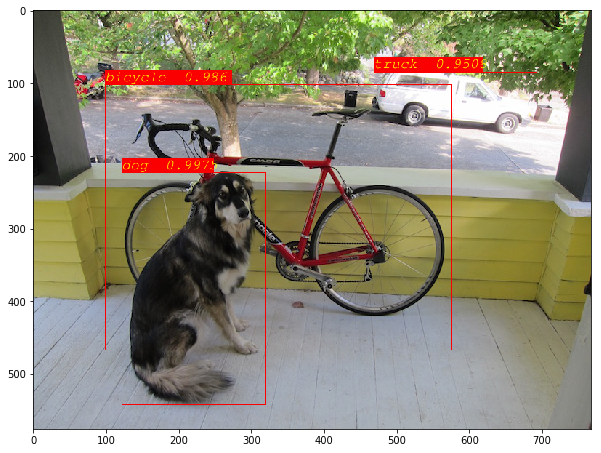

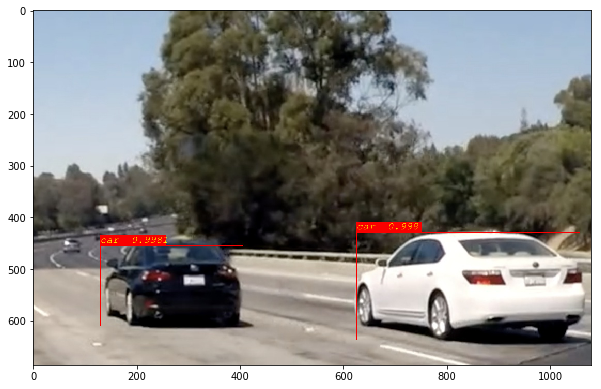

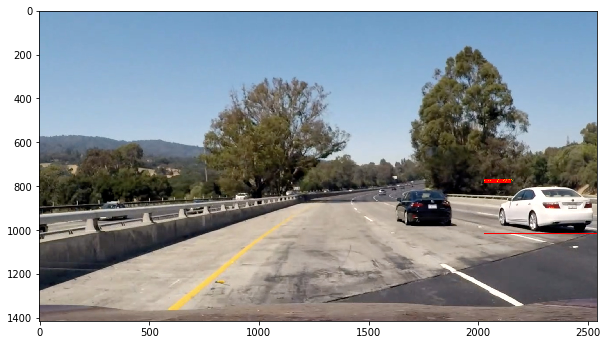

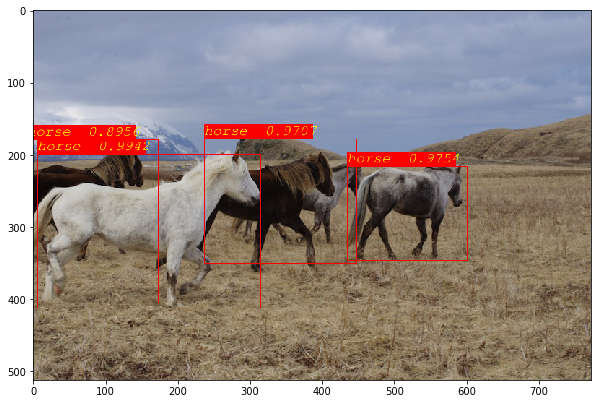

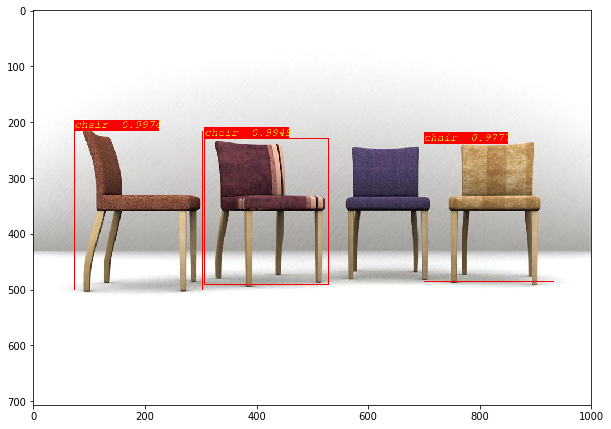

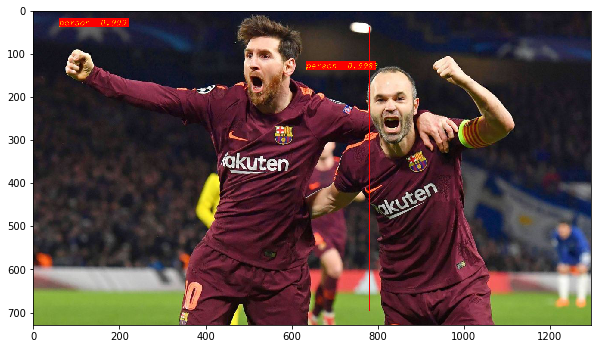

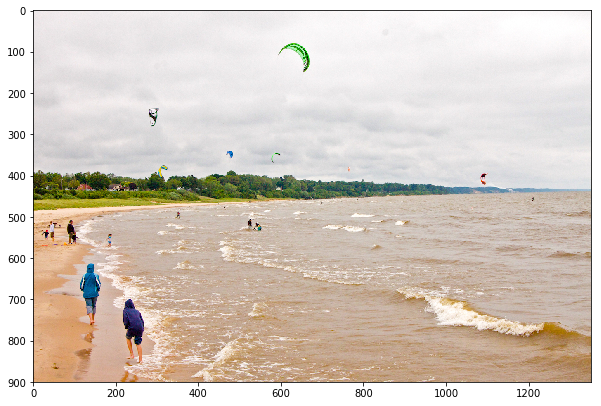

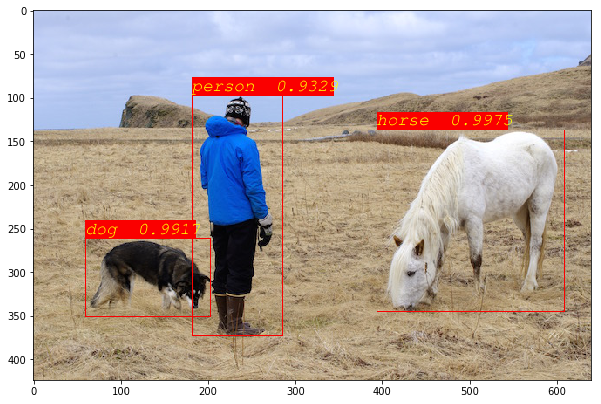

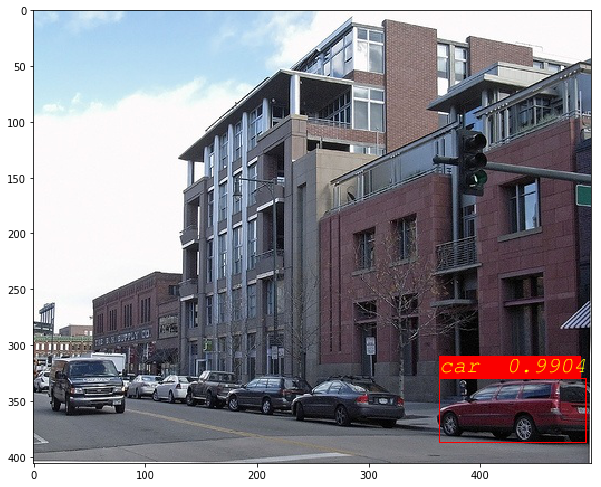

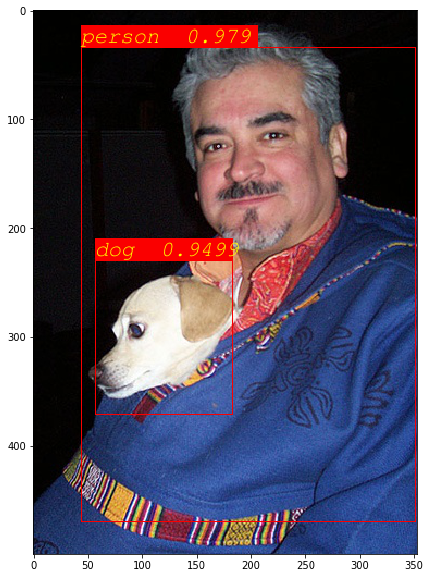

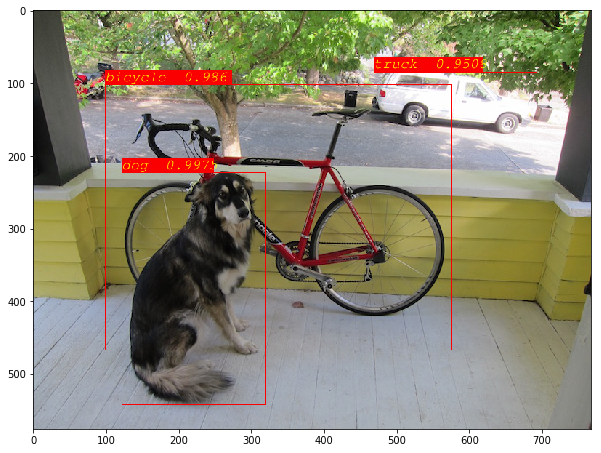

In [24]:
num_batch = yolo_outputs[0].shape[0]

for b in range(num_batch):
    
    class_box_score_dict = {}
    for i, c in enumerate(class_names):
        # 在某类别下，找出那些存在box的概率超过某阈值的grid
        c_index_list = list(np.argwhere(box_score[b][:, i]>0.6).reshape(-1))

        if len(c_index_list) == 0:
            continue

        # 在某类别下，找出对应的box和概率, 然后对该类别下找出的box做非最大值抑制，保留最可能的若干box，
        # 然后更新{类别名称: [(xmin,ymin,xmax,ymax,score),...]}
        boxs = box_xymin_xymax[b][c_index_list]
        scores = box_score[b][c_index_list, i]
        class_box_score_dict.update({c: non_max_suspension(scores, boxs, iou_threshold=0.5, max_box=10)})

    
    #打开一个图像，画出其所有的box
    img = Image.open('test_image/original/'+img_list[b])
    w, h  = img.size
    draw = ImageDraw.Draw(img)
    fnt = ImageFont.truetype('freemonooblique.ttf', 20)

#     for mm in np.argwhere(box_score>0.01):


#         a = mm[1:-1]
#         xmin,ymin = box_xy[b][a[0]] - box_wh[b][a[0]]/2
#         xmax,ymax = box_xy[b][a[0]] + box_wh[b][a[0]]/2

#         draw_xmin, draw_xmax = np.array([xmin, xmax]) * h
#         draw_ymin, draw_ymax = np.array([ymin, ymax]) * w
#         draw.rectangle([draw_xmin, draw_ymin, draw_xmax,draw_ymax])

    for key in class_box_score_dict.keys():

        for item in class_box_score_dict[key]:

            xmin,ymin,xmax,ymax = item[:4]
            prob = str(round(item[4], 4))
            draw_xmin, draw_xmax = np.array([xmin, xmax]) * w
            draw_ymin, draw_ymax = np.array([ymin, ymax]) * h
#             draw.rectangle([draw_xmin, draw_ymin, draw_xmax,draw_ymax], width=2, outline=(250))
            draw.rectangle([draw_xmin, draw_ymin, draw_xmax,draw_ymax], outline=(250))

#             draw.rectangle([draw_xmin, draw_ymin-20, draw_xmin+ 12*len(key), draw_ymin], fill=250,width=2, outline=(250))
            draw.rectangle([draw_xmin, draw_ymin-20, draw_xmin+ 12*len(key)+90, draw_ymin], fill=250, outline=(250))

            draw.text((draw_xmin, draw_ymin-20), key+'  '+ prob, font=fnt, fill=(255,255,0))


    plt.figure(figsize=(10,10))
    plt.imshow(np.asarray(img))    
    

## 四、视频实时测试

<center>
<video width="400" height="200" src="test_image/road.mp4" type="video/mp4" controls>
</video>
</center>
<caption><center> 待预测视频 </center></caption>

<img src="readme_pic/car_predict.png" style="width:400px;height:200;">
<caption><center> 视频预测结果:截取了含目标物体的区域 </center></caption>

<center>
<video width="400" height="200" src="test_image/output_box.mp4" type="video/mp4" controls>
</video>
</center>
<caption><center> 视频预测结果 </center></caption>

In [24]:
import numpy as np
import cv2 as cv


cap = cv.VideoCapture('test_image/road.mp4')
# cap = cv.VideoCapture(0) # 可实时测试摄像头
print(cap.isOpened())
count = 0


# 视频保存的参数设置
# 此处的shape一定要和保存的图像尺寸一样
sz = (int(cap.get(cv.CAP_PROP_FRAME_WIDTH)),
        int(cap.get(cv.CAP_PROP_FRAME_HEIGHT)))
sz = (int(560), int(300))   

fps = 5
#fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
#fourcc = cv2.VideoWriter_fourcc('m', 'p', 'e', 'g')
fourcc = cv.VideoWriter_fourcc(*'mpeg')
## open and set props
vout = cv.VideoWriter()
vout.open('test_image/output_box.mp4',fourcc,fps,sz,True)
 
count = 0
while(count<35):
    count += 1
    ret, img = cap.read()
    
    img = img[300:600,700:1260]
    w,h = img.shape[:2]
    
    img  = cv.resize(img,(416,416))
    img = np.expand_dims(img, 0)
    img = img/225.
    
    # 一帧一帧地预测（应该可以多帧同时预测，按帧播放、保存即可）
    yolo_outputs = model.predict(img)
    
    
    # 输出做转换
    yolo_outputs_1 = yolo_outputs[:, :13*13*255].reshape(-1,13,13,255)
    yolo_outputs_2 = yolo_outputs[:, 13*13*255: 13*13*255+26*26*255].reshape(-1,26,26,255)
    yolo_outputs_3 = yolo_outputs[:, 13*13*255+26*26*255: ].reshape(-1,52,52,255)
    yolo_outputs = [yolo_outputs_1, yolo_outputs_2, yolo_outputs_3]
    
    
    box_xymin_xymax, box_score = output_score_and_xywh(yolo_outputs, anchors, grids,input_shape=416)
    
    img = np.squeeze(img)
    img = draw_box(img, box_xymin_xymax, box_score)
    img = cv.resize(img, (h, w)) 
    cv.imshow('img',img)
    vout.write(img)
    
    if cv.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
vout.release()
cv.destroyAllWindows()

True


## 五、训练模型

In [27]:
model.compile(optimizer='adam', loss=yolo_v3_loss)

In [28]:
history = model.fit(x=data_x, y=data_y, batch_size=2, epochs=10)

Instructions for updating:
Use tf.cast instead.
10/10 [==============================] - 57s 6s/sample - loss: 168.1375


## 可视化

## 参考

https://blog.csdn.net/leviopku/article/details/82660381  
https://github.com/qqwweee/keras-yolo3